# **Data Visualization**

## Objectives

* The client is interested to have a study to visually differentiate a parasitized and uninfected cell.

## Inputs

- inputs/datasets/cherry-leaves/test
- inputs/datasets/cherry-leaves/train
- inputs/datasets/cherry-leaves/validation 

## Outputs

- Image shape embeddings pickle file.
- Mean and variability of images per label plot.
- Plot to distinguish the contrast between parasite-contained and uninfected cell images.
- Generate code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard.

## Additional Comments

- The avarage dimension of the raw images is 256px width by 256px height
- Looking at the avarage images:
   - the healthy leaves appear to have a more uniform green colour than the powdery mildew leaf.
   - and the veins appear more visible in the mildew leaf compared to the healthy leaf
- From the image montage the mildew leaves have white streaks on them often along the leaf veins.



---

# Import libraries

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
# sns.set_style("white")
from matplotlib.image import imread

# Change working directory

In [5]:
import os
current_dir = os.getcwd()
print("Current directory:", current_dir)

Current directory: /workspace/mildew_cherry_detection/jupyter_notebooks


In [6]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [7]:
work_dir = os.getcwd()
print("New current directory:", work_dir) 

New current directory: /workspace/mildew_cherry_detection


## Set input directories

In [12]:
# Define paths
data_dir = '/inputs/datasets/raw'
train_dir = '/inputs/datasets/train'
val_dir = '/inputs/datasets/val'
test_dir = '/inputs/datasets/test'
file_path = 'models'

## Set output directory

In [8]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

## Set labels

Verify if the train directory.

In [18]:
# Verify if the train directory exists
train_dir = 'inputs/datasets/train'
train_dir_full_path = os.path.join(os.getcwd(), train_dir)
print("Full path to train directory:", train_dir_full_path)

Full path to train directory: /workspace/mildew_cherry_detection/inputs/datasets/train


In [17]:
# Check if the directory exists
if os.path.exists(train_dir_full_path):
    print(f"Directory exists: {train_dir_full_path}")
else:
    print(f"Directory does not exist: {train_dir_full_path}")

Directory exists: /workspace/mildew_cherry_detection/inputs/datasets/train


Set labels from the train dataset list of directory 

In [15]:
# Set the labels
labels = os.listdir(train_dir)
print('Label for the images are', labels)


Label for the images are ['healthy', 'mildew']


---

# Data visualisation of image data

## Image Shape 
 Compute average images size on train set.

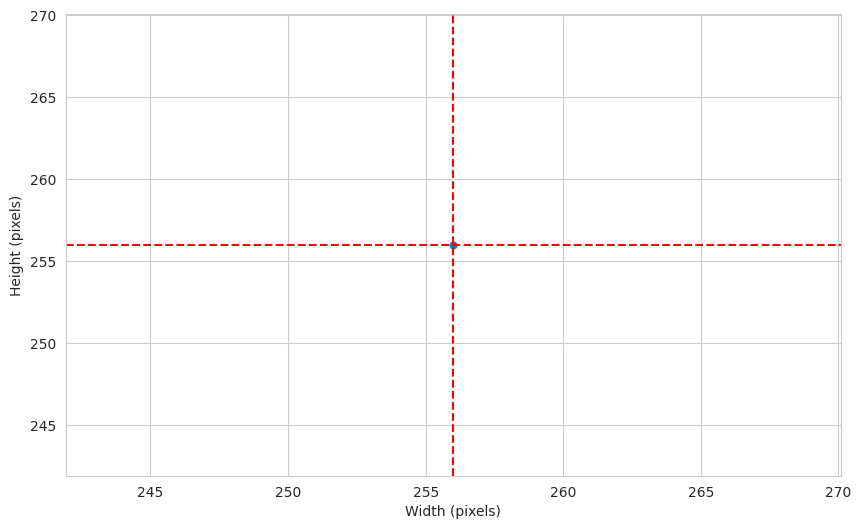

Width average: 256.0 
Height average: 256.0


In [25]:
import os
from matplotlib.image import imread
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib

# Function to calculate image dimensions
def calculate_image_dimensions(image_path):
    dimensions = [imread(os.path.join(image_path, label, img)).shape for label in os.listdir(image_path) for img in os.listdir(os.path.join(image_path, label))]
    return dimensions

# Get image dimensions
dimensions = calculate_image_dimensions(train_dir)
dim1, dim2 = zip(*[(d[0], d[1]) for d in dimensions])

# Plot image dimensions
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
dim1_mean, dim2_mean = np.mean(dim1), np.mean(dim2)
plt.axvline(x=dim2_mean, color='r', linestyle='--')
plt.axhline(y=dim1_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")




Set image shape for the model

In [28]:
# Define the path to save the model
file_path = "/workspace/mildew_cherry_detection/models" 

# Set and save image shape
image_shape = (int(dim1_mean), int(dim2_mean), 3)
joblib.dump(image_shape, os.path.join(file_path, "image_shape.pkl"))

['/workspace/mildew_cherry_detection/models/image_shape.pkl']

set a manual shape for the model

In [29]:
manual_shape = (64, 64, 3)
joblib.dump(manual_shape, os.path.join(file_path, "image_shape_manual.pkl"))

['/workspace/mildew_cherry_detection/models/image_shape_manual.pkl']

---



## Average and Variability of Images Per Label

### Function to Load Images as Arrays
The function `load_image_as_array` loads images from a specified directory, resizes them, and normalizes their pixel values. This step is crucial for preparing the image data for analysis and model training.


In [19]:
from tensorflow.keras.preprocessing import image
import numpy as np
import os

def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):
    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)
    for label in labels:
        counter = 0
        for image_filename in os.listdir(os.path.join(my_data_dir, label)):
            if counter < n_images_per_label:
                img = image.load_img(os.path.join(my_data_dir, label, image_filename), target_size=new_size)
                img_resized = image.img_to_array(img) / 255 if image.img_to_array(img).max() > 1 else image.img_to_array(img)
                X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1
    return X, y

# Load image shapes and labels into arrays
# Define the image_shape variable
image_shape = (50, 50)

# Load the images as arrays
X, y = load_image_as_array(my_data_dir=train_dir, new_size=image_shape, n_images_per_label=30)


### Plot and Save Mean and Variability of Images Per Label
The function `plot_mean_variability_per_labels` calculates and plots the mean and standard deviation of images for each label. This helps visualize the central tendency and dispersion of pixel values for each label, providing insights into the variability within each class.


==== Label healthy ====
Image Shape: (50, 50, 3)
==== Label mildew ====
Image Shape: (50, 50, 3)


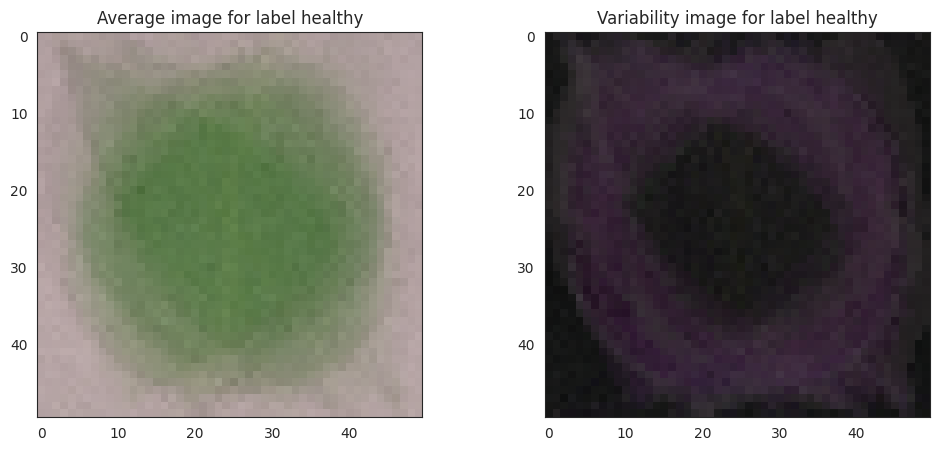

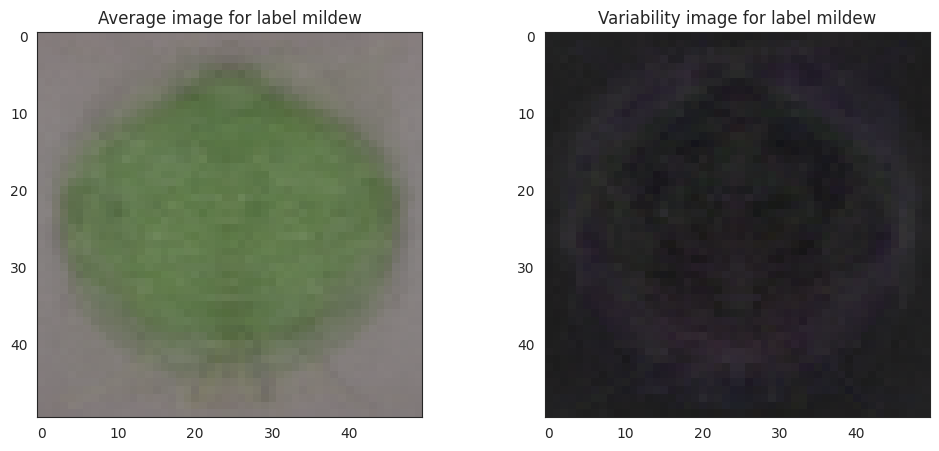

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    for label_to_display in np.unique(y):
        sns.set_style("white")
        boolean_mask = y == label_to_display
        arr = X[boolean_mask]
        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')
        if save_image:
            plt.savefig(os.path.join(file_path, f"avg_var_{label_to_display}.png"), bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)


## Difference Between Average Images of Different Labels
The functions `subset_image_label` and `diff_bet_avg_image_labels_data_as_array` calculate and plot the differences between the average images of two labels. This highlights the differences between classes, which can be useful for understanding the key features that distinguish them.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


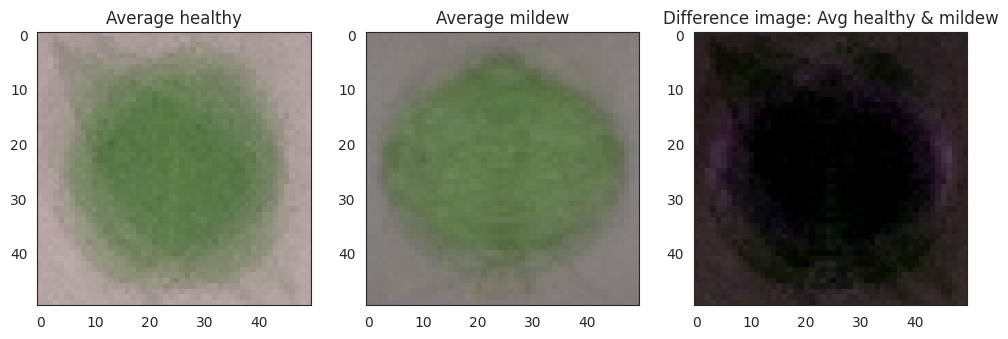

In [22]:
def subset_image_label(X, y, label_to_display):
    boolean_mask = y == label_to_display
    return X[boolean_mask]

def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    sns.set_style("white")
    if label_1 not in np.unique(y) or label_2 not in np.unique(y):
        print(f"Either label {label_1} or label {label_2} is not in {np.unique(y)}")
        return

    label1_avg = np.mean(subset_image_label(X, y, label_1), axis=0)
    label2_avg = np.mean(subset_image_label(X, y, label_2), axis=0)
    difference_mean = label1_avg - label2_avg

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(os.path.join(file_path, "avg_diff.png"), bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

diff_bet_avg_image_labels_data_as_array(X=X, y=y, label_1='healthy', label_2='mildew', figsize=(12, 10), save_image=True)


---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
